In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import make_regression, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, 
                             f1_score, roc_auc_score)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from regression import plot_data
from regression import PALETTE

In [3]:
def calculate_metrics(y_true, y_pred, *metrics):
    for metric in metrics:
        print("{} = {:.3f}".format(metric.__name__, metric(y_true, y_pred)))

regression_metrics = [r2_score, mean_squared_error]
classification_metrics = [accuracy_score, f1_score]

# GP models 

We provide a scikt-learn-like wrapper over [GPy](http://sheffieldml.github.io/GPy/) library for the most common models based on Gaussian processes

In [19]:
from edrgp.gp_model import GaussianProcessClassifier, GaussianProcessRegressor

print(GaussianProcessRegressor(), GaussianProcessClassifier(), sep='\n\n')

GaussianProcessRegressor(Y_metadata=None, kernel_options=None, kernels=None,
             mean_function=None, method='optimize', noise_var=1.0,
             normalizer=None)

GaussianProcessClassifier(Y_metadata=None, kernel_options=None, kernels=None,
             mean_function=None, method='optimize')


The main parameters that should be carefully considered are `kernels`, `kernel_options`, `method` and `normalizer` for regression. Below are some examples, for more details see the documentation.

## Regression 

### `normalizer` 

Let's consider linear function

In [6]:
def generate_linear_data(bias):
    X, y = make_regression(n_samples=300, n_features=2, noise=0.5, bias=bias, 
                           random_state=0)
    return train_test_split(X, y, test_size=0.33, random_state=42)

r2_score = 1.000
mean_squared_error = 0.260


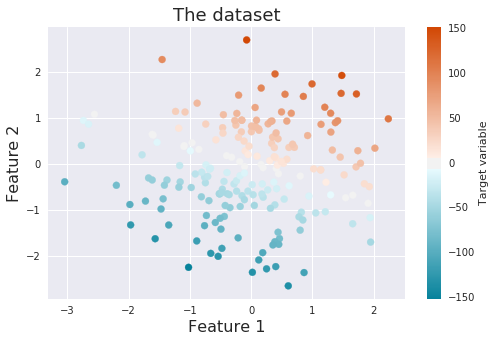

In [7]:
X_train, X_test, y_train, y_test = generate_linear_data(bias=0)
plot_data(X_train, y_train)

# Let's use GP with linear kernel
GPR = GaussianProcessRegressor('Linear')
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

As we can see the results are good, but let's add bias to target. It is the same function but with bias

r2_score = -1.628
mean_squared_error = 10241.449


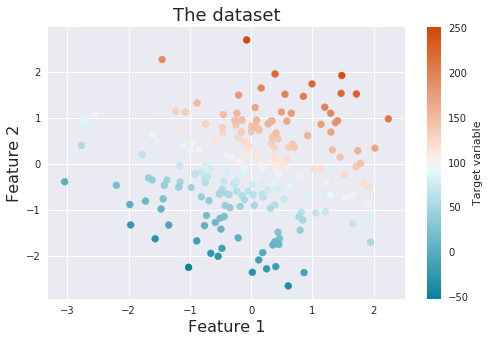

In [8]:
X_train, X_test, y_train, y_test = generate_linear_data(bias=100)
plot_data(X_train, y_train)

GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

We can see that result is very strange. It leads us to fact that we should normalize target before passing data to GaussianProcessRegressor. To do it you can specify `normalizer=True`.

In [9]:
GPR = GaussianProcessRegressor('Linear', normalizer=True)
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

r2_score = 0.983
mean_squared_error = 66.535


### `ARD` for RBF kernel 

In [10]:
from scipy.stats import multivariate_normal
from edrgp.datasets import get_beta_inputs, get_edr_target

Consider nonlinear model depending only on first two features of data $ y =(x_1^3+x_2)(x_1-x_2^3)$

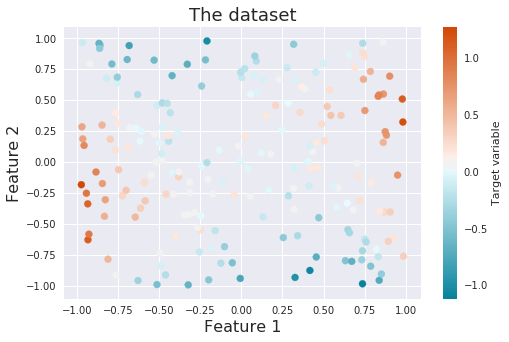

In [11]:
X = get_beta_inputs(200, 5)
y = get_edr_target(X[:, :2], sigma=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

plot_data(X[:, :2], y)

Here we can see that kernel option `ARD=True` for RBF kernel can show better performance. This option means that there is not only one lengthscale for all features, but every feature has it's own lengthscale

In [12]:
print('ARD = False\n==========')
GPR = GaussianProcessRegressor('RBF', normalizer=True)
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)
print()
print("ARD = True\n=========")
GPR = GaussianProcessRegressor('RBF', [{'ARD': True}], normalizer=True)
GPR.fit(X_train, y_train)
y_pred = GPR.predict(X_test)
calculate_metrics(y_test, y_pred, *regression_metrics)

ARD = False
r2_score = 0.833
mean_squared_error = 0.033

ARD = True
r2_score = 0.924
mean_squared_error = 0.015


This option is also applicable for classification

## Classification 

In [13]:
def generate_circles_data():
    X, y = make_circles(n_samples=200, noise=0.1, random_state=0, factor=0.7)
    return X, y, train_test_split(X, y, test_size=0.33, random_state=42)

def plot_classificaton_data(X, y):
#     plt.figure(figsize=[8, 6])
    for target in np.unique(y):
        plt.scatter(X[:, 0][y==target], X[:, 1][y==target], label=target, s=40, edgecolors='k')
    plt.legend()
    plt.title('The dataset', fontsize=18)
    plt.xlabel('Feature 1', fontsize=16)
    plt.ylabel('Feature 2', fontsize=16)

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

def plot_desicion_rule(model, X, y):
    plt.figure(figsize=(7, 6))
    xx, yy = get_grid(X)
    model.fit(X, y)
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx, yy, predicted, cmap='winter', alpha=0.2)
    plot_classificaton_data(X, y)

Consider circles dataset

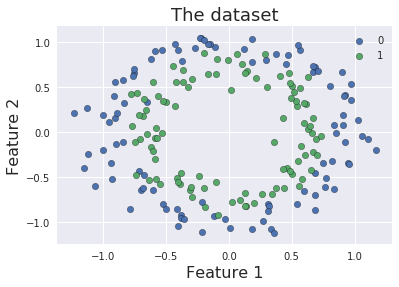

In [14]:
X, y, (X_train, X_test, y_train, y_test) = generate_circles_data()
plot_classificaton_data(X, y)

It's obvious that linear kenrel will not work well for this data, but let's see it 

accuracy_score = 0.470
f1_score = 0.444
roc_auc_score = 0.466


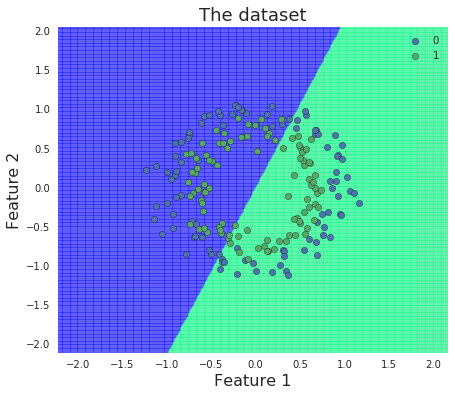

In [15]:
GPC = GaussianProcessClassifier('Linear')
GPC.fit(X_train, y_train)
y_pred = GPC.predict(X_test)
y_pred_proba = GPC.predict_proba(X_test)
calculate_metrics(y_test, y_pred, *classification_metrics)
print("{} = {:.3f}".format(roc_auc_score.__name__, 
                           roc_auc_score(y_test, y_pred_proba)))
plot_desicion_rule(GPC, X, y)

We can achieve better perfomance with non-linear kernel, for example RBF

accuracy_score = 0.879
f1_score = 0.875
roc_auc_score = 0.989


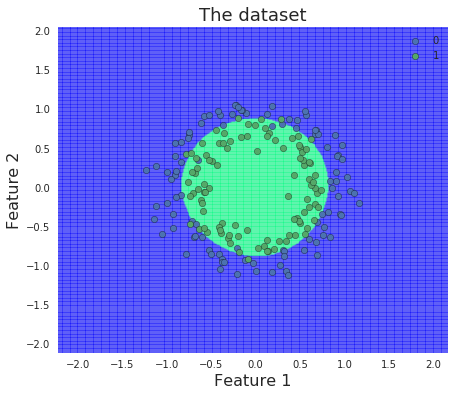

In [16]:
GPC = GaussianProcessClassifier('RBF')
GPC.fit(X_train, y_train)
y_pred = GPC.predict(X_test)
y_pred_proba = GPC.predict_proba(X_test)
calculate_metrics(y_test, y_pred, *classification_metrics)
print("{} = {:.3f}".format(roc_auc_score.__name__, 
                           roc_auc_score(y_test, y_pred_proba)))

plot_desicion_rule(GPC, X, y)

## `method` = {optimize, optimize_restarts} 

You can initialize GP model with one of this options. _optimize_ means that optimization process during fit will only start once. _optimize_restarts_ means that it will run optimization process several times and than choose the best run. Moreover in `fit` we can specify number of restarts (default 10) and whether to print results on every run.

In [17]:
GPC = GaussianProcessClassifier('RBF', method='optimize_restarts')

for num_restarts, verbose in zip([5, 10], [True, False]):
    mes = "Number of restarts = {}, verbose = {}".format(num_restarts, verbose)
    print(mes)
    print("="*len(mes))
    GPC.fit(X_train, y_train, num_restarts=num_restarts, verbose=verbose)
    print()
    y_pred = GPC.predict(X_test)
    y_pred_proba = GPC.predict_proba(X_test)
    calculate_metrics(y_test, y_pred, *classification_metrics)
    print("{} = {:.3f}".format(roc_auc_score.__name__, 
                               roc_auc_score(y_test, y_pred_proba)))
    print()

# plot_desicion_rule(GPC, X, y)

Number of restarts = 5, verbose = True
Optimization restart 1/5, f = 55.507222868601815
Optimization restart 2/5, f = 62.800659906857845
Optimization restart 3/5, f = 50.862702847672935
Optimization restart 4/5, f = 53.46330975543855
Optimization restart 5/5, f = 57.91198727791645

accuracy_score = 0.864
f1_score = 0.862
roc_auc_score = 0.989

Number of restarts = 10, verbose = False

accuracy_score = 0.879
f1_score = 0.875
roc_auc_score = 0.988

